Target:

1. Get the set-up right
2. Set Transforms
3. Set Data Loader
4. Set Basic Working Code
5. Set Basic Training  & Test Loop
6. Results:
    1. Parameters: 6.3M
    2. Best Training Accuracy: 99.99
    3. Best Test Accuracy: 99.40
7. Analysis:
    1. Extremely Heavy Model for such a problem
    2. Model is over-fitting, but we are changing our model in the next step

## 1. Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## 2. Calculate Mean & Standard Deviation of Raw Data to Normalize the Input Data/Tensor Later

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## 3.1 Record Some Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
cuda = torch.cuda.is_available()

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(exp, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])


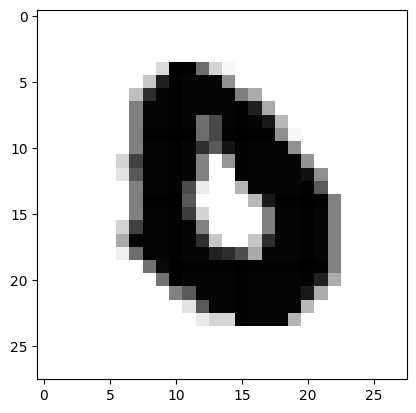

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = exp.train_data
train_data = exp.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## 3.2 A Bit MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

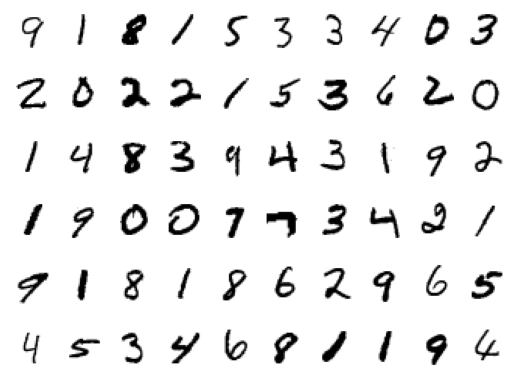

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## 4. Define your NN Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x, -1)

## 5. Observe the Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

## 6. SEED - finish randomness of PyTorch

Before we start training, get rid of PyTorch SEED Issue

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


## 7. Import & Define Train/Test Data with Normalized Tensors

1.   Define Appropriate Transformations
2.   Apply the Transformations to Input Dataset - both Train & Test


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## 8. Create Dataset Batches

In [ ]:

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

## Define Training and Testing Methods for Neural Network

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Run, Train and Test the Model

In [16]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.9196269512176514 Batch_id=468 Accuracy=54.58: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]



Test set: Average loss: 0.7907, Accuracy: 6713/10000 (67.13%)

EPOCH: 1


Loss=0.019820498302578926 Batch_id=468 Accuracy=90.33: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]



Test set: Average loss: 0.0419, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.04723230376839638 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:19<00:00, 24.09it/s]



Test set: Average loss: 0.0324, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.01566501148045063 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]



Test set: Average loss: 0.0301, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.07675456255674362 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:19<00:00, 24.24it/s]



Test set: Average loss: 0.0332, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.012977040372788906 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]



Test set: Average loss: 0.0281, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.0005216829595156014 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]



Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.018824273720383644 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:19<00:00, 24.04it/s]



Test set: Average loss: 0.0267, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.006032818462699652 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]



Test set: Average loss: 0.0300, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.010401677340269089 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:19<00:00, 23.61it/s]



Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=4.025635644211434e-05 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]



Test set: Average loss: 0.0292, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=5.4899166570976377e-05 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]



Test set: Average loss: 0.0263, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.015751738101243973 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:19<00:00, 24.22it/s]



Test set: Average loss: 0.0336, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.00011513064237078652 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]



Test set: Average loss: 0.0275, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.0006300051463767886 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]



Test set: Average loss: 0.0325, Accuracy: 9907/10000 (99.07%)

EPOCH: 15


Loss=7.524013926740736e-05 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]



Test set: Average loss: 0.0301, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.0002645088534336537 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:19<00:00, 24.26it/s]



Test set: Average loss: 0.0302, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=2.94221899821423e-05 Batch_id=468 Accuracy=99.98: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]



Test set: Average loss: 0.0285, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.000617115932982415 Batch_id=468 Accuracy=99.98: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]



Test set: Average loss: 0.0313, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=6.808413218095666e-06 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]



Test set: Average loss: 0.0307, Accuracy: 9940/10000 (99.40%)

